# Final HW 1 - 김영인

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset # for loading dataset (mnist)
import torchvision.transforms as transforms # for processing datasets
from torch.utils.data import DataLoader # for making dataset easier to use 

from matplotlib import pyplot as plt
import numpy as np

device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"device: {device0}, {device1}") if torch.cuda.is_available() else print("device: cpu")

device: cuda:0, cuda:1


# 1. MNIST

## Hyper parameter setting

In [44]:
lr = 1e-1
epochs = 40
batch_size = 32
act = nn.ReLU()
display_step = 10
dropout_rate = .2
scheduler_step = 1
scheduler_gamma = 0.99

## Load data & Pre-process data

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


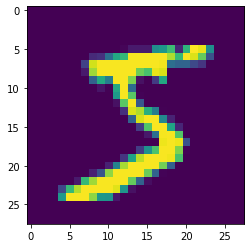

In [45]:
# load data
train_data = dataset.MNIST("./", train = True, 
                           transform = transforms.ToTensor(),
                           target_transform = None, 
                           download = True)
test_data = dataset.MNIST("./", train = False,
                          transform = transforms.ToTensor(),
                          target_transform = None,
                          download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([9, 4, 9, 6, 6, 2, 8, 4, 1, 3, 6, 3, 1, 8, 4, 1, 4, 5, 8, 4, 3, 9, 3, 4,
        9, 7, 1, 2, 2, 9, 4, 2])


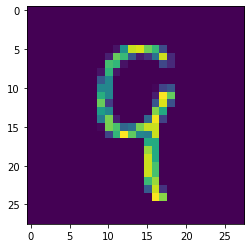

10000


In [48]:
# preprocess data
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           shuffle = True, 
                                           num_workers = 1,
                                           drop_last = True) 
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = 10000,
                                          shuffle = True,
                                          num_workers = 1,
                                          drop_last = True)

# check the data (배치 중 하나만 가져와서 확인)
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

## Model Setting

In [46]:
# model
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.feature_extraction = nn.Sequential(
            # origin : 1 * 28 * 28
            nn.Conv2d(1, 16, 3, padding = 1), # 16 * 28 * 28
            nn.BatchNorm2d(16),
            act,
            nn.MaxPool2d(2,2), # 16 * 14 * 14
            nn.Conv2d(16, 32, 3, padding = 1), # 32 * 14 * 14
            nn.BatchNorm2d(32),
            act,
            nn.MaxPool2d(2,2) # 32 * 7 * 7
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 100),
            nn.BatchNorm1d(100),
            act,
            nn.Dropout(dropout_rate),
            nn.Linear(100,10)
        )
    def forward(self, x):
        feature_extraction = self.feature_extraction(x)
        flatten = feature_extraction.view(x.shape[0], -1)         
        logit = self.classifier(flatten)
        
        return logit
        
model = CNN().to(device0)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size = scheduler_step,
                                      gamma = scheduler_gamma)

## Train

In [49]:
loss_array = []

# train the model
for i in range(epochs):
    scheduler.step()
    for index, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device0)
        label = label.to(device0)        
        
        output = model.forward(data)
        loss = loss_function(output, label)
        
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print(f'{i} epoch loss: {loss}')
        loss_array.append(loss.cpu().detach().numpy())
        

0 epoch loss: 0.22368621826171875
10 epoch loss: 0.0008498001261614263
20 epoch loss: 0.00013486214447766542
30 epoch loss: 0.0019031378906220198


## test

In [50]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device0)
        label = label.to(device0)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

Accuracy of the model: 0.9939000010490417


## Plot result

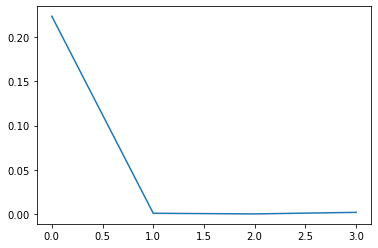

prediction : (10000,)
true label : (10000,)


array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1130,    0,    1,    0,    0,    2,    1,    1,    0],
       [   1,    0, 1026,    0,    1,    0,    0,    4,    0,    0],
       [   0,    0,    1, 1005,    0,    3,    0,    0,    1,    0],
       [   0,    0,    0,    0,  977,    0,    0,    0,    0,    5],
       [   0,    0,    0,    6,    0,  885,    1,    0,    0,    0],
       [   3,    1,    0,    1,    1,    0,  951,    0,    1,    0],
       [   0,    1,    2,    0,    0,    0,    0, 1025,    0,    0],
       [   1,    0,    2,    1,    0,    1,    0,    0,  968,    1],
       [   0,    0,    0,    1,    4,    4,    0,    4,    1,  995]])

In [53]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred